**Chapter 9 – Up and running with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 9._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

**Warning**: this is the code for the 1st edition of the book. Please visit https://github.com/ageron/handson-ml2 for the 2nd edition code, with up-to-date notebooks using the latest library versions. In particular, the 1st edition is based on TensorFlow 1, while the 2nd edition uses TensorFlow 2, which is much simpler to use.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [60]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow.compat.v1 as tf

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
except Exception:
    pass

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Creating and running a graph

In [61]:
import tensorflow as tf

reset_graph()
# 无法执行sess.run()的原因是tensorflow版本不同导致的，tensorflow版本2.0无法兼容版本1.0.
tf.compat.v1.disable_eager_execution()

x = tf.compat.v1.Variable(3, name="x")
y = tf.compat.v1.Variable(4, name="y")
f = x*x*y + y + 2

In [62]:
print(x.initializer)

name: "x/Assign"
op: "AssignVariableOp"
input: "x"
input: "x/Initializer/initial_value"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}



In [63]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [64]:
# 需要打开一个TensorFlow的会话，然后用它来初始化变量并求值f。
# 一个TensorFlow的会话会将计算分发到诸如CPU和GPU设备上并执行，它还持有所有变量的值
sess = tf.compat.v1.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [65]:
sess.close()

In [66]:
# 调用x.initializer.run等价于调用
# tf.get_default_session（） .run（x.initializer），同样， f.eavl等价于 tf.get_default_session（） .run（f）。
# 这种写法不仅可以增加可读性，还可使会话在块中的代码执行结束后自动关闭。
with tf.compat.v1.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [67]:
result

42

In [68]:
# 除了手工为每个变量调用初始化器之外，还可以使用global_variables_initializer（）函数来完成同样的动作。
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    init.run()
    result = f.eval()

In [69]:
result

42

In [70]:
init = tf.compat.v1.global_variables_initializer()

In [71]:
# 创建一个InteractiveSession。 它和常规会话的不同之处在于InteractiveSession在创建时会将自己设置为默认会话， 
# 因此你无须使用with块
sess = tf.compat.v1.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [72]:
sess.close()

In [73]:
result

42

# Managing graphs

In [74]:
reset_graph()

x1 = tf.compat.v1.Variable(1)
x1.graph is tf.compat.v1.get_default_graph()

True

In [75]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [76]:
x2.graph is tf.compat.v1.get_default_graph()

False

In [77]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.compat.v1.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [78]:
with tf.compat.v1.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression

## Using the Normal Equation

In [79]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

# 这些矩阵相关函数transpose（）、 matmul（）和matrix_inverse（）都是自解释的，与以往一样，它们不会立即执行，
# 现在只是定义了图中的节点，具体计算要等到图运行时才会发生。
# 与直接用NumPy来计算正规方程相比，上述代码的最大好处是如果你有GPU， TensorFlow会把计算自动分发到GPU上去
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.compat.v1.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.compat.v1.Session() as sess:
    theta_value = theta.eval()

In [80]:
theta_value

array([[-3.6896515e+01],
       [ 4.3682209e-01],
       [ 9.4436919e-03],
       [-1.0742678e-01],
       [ 6.4522374e-01],
       [-3.9421757e-06],
       [-3.7879660e-03],
       [-4.2084768e-01],
       [-4.3402091e-01]], dtype=float32)

Compare with pure NumPy

In [81]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


Compare with Scikit-Learn

In [82]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first. We could do this using TF, but let's just use Scikit-Learn for now.

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [84]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### Manually computing the gradients

In [85]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

# 常量
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
# 变量
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 预测
y_pred = tf.matmul(X, theta, name="predictions")
# 误差
error = y_pred - y
# 均方差
mse = tf.reduce_mean(tf.square(error), name="mse")
# 梯度
gradients = 2/m * tf.matmul(tf.transpose(X), error)
# 训练
training_op = tf.compat.v1.assign(theta, theta - learning_rate * gradients)

# 全局变量初始化
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450037
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.5396291
Epoch 700 MSE = 0.5365093
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473


In [86]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770885],
       [ 0.3617837 ],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.63752776]], dtype=float32)

### Using autodiff

Same as above except for the `gradients = ...` line:

In [87]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

# 常量
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
# 变量
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 预测
y_pred = tf.matmul(X, theta, name="predictions")
# 误差
error = y_pred - y
# 均方差
mse = tf.reduce_mean(tf.square(error), name="mse")

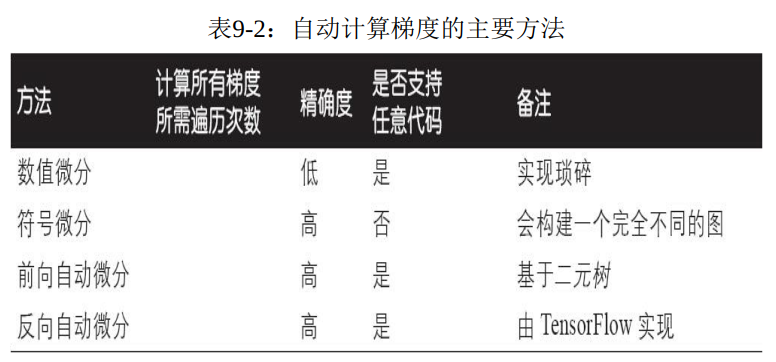

In [88]:
# 自动微分
# gradients（） 函数接受一个操作符（这里是mse） 和一个参数列表（这里是theta） 作为参数， 
# 然后它会创建一个操作符的列表来计算每个变量的梯度。 
gradients = tf.gradients(mse, [theta])[0]

In [89]:
# 训练
training_op = tf.compat.v1.assign(theta, theta - learning_rate * gradients)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450037
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.5396291
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


How could you find the partial derivatives of the following function with regards to `a` and `b`?

In [90]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [91]:
my_func(0.2, 0.3)

-0.21253923284754914

In [92]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.compat.v1.global_variables_initializer()

Let's compute the function at $a=0.2$ and $b=0.3$, and the partial derivatives at that point with regards to $a$ and with regards to $b$:

In [93]:
with tf.compat.v1.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388495, 0.19671395]


### Using a `GradientDescentOptimizer`

In [94]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

# 常数
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
# 变量
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 预测
y_pred = tf.matmul(X, theta, name="predictions")
# 误差
error = y_pred - y
# 均方差
mse = tf.reduce_mean(tf.square(error), name="mse")

In [95]:
# 梯度下降优化器
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
# 均方差最小化
training_op = optimizer.minimize(mse)

In [96]:
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450037
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.5396291
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### Using a momentum optimizer

In [97]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [98]:
# 使用动量优化器（momentum optimizer）（比梯度下降优化器的收敛速度快很多）
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [99]:
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

In [100]:
with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# Feeding data to the training algorithm

## Placeholder nodes

In [101]:
reset_graph()
# 要创建一个占位符节点， 需要调用placeholder（） 函数并指定输出张量的数据类型。 
# 另外， 如果你想强制张量的形状， 也可以在此指定。 如果给维度设置None值， 则表示“任意尺寸”。 
A = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
B = A + 5
# 当对B求值时， 给eval（） 方法传一个feed_dict， 并指定A的值。 
# 注意， A必须是2阶的（比如， 一个二维数组） 而且必须有3列（否则会抛异常） ， 不过可以有任意多行。
with tf.compat.v1.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

[[6. 7. 8.]]


In [102]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


## Mini-batch Gradient Descent

In [105]:
n_epochs = 1000
learning_rate = 0.01

In [106]:
reset_graph()

# 创建占位符节点 
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")

In [107]:
"""
tf.random_uniform(shape,minval=0,maxval=None,dtype=tf.float32,seed=None,name=None)
从均匀分布中输出随机值。生成的值在该[minval, maxval)范围内遵循均匀分布。下限 minval包含在范围内，而上限maxval被排除在外。对于浮点数，默认范围是[0,1)。对于整数，至少maxval必须明确地被指定。在整数情况下，随机整数稍有偏差，除非maxval-minval是2的精确幂。对于maxval-minval的值，偏差很小，明显小于输出(232 或者 264)的范围。
shape：一维整数张量或Python数组；输出张量的形状。
minval：dtype类型的0维张量或Python值；生成的随机值范围的下限。默认为0。
maxval：dtype类型的0维张量或Python值；要生成的随机值范围的上限。如果dtype是浮点,则默认为1。
dtype：输出的类型：float16、float32、float64、int32、orint64。
seed：一个 Python 整数。用于为分布创建一个随机种子。
name：操作的名称(可选)。
"""
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
# tf.reduce_mean 函数用于计算张量tensor沿着指定的数轴（tensor的某一维度）上的的平均值，主要用作降维或者计算tensor（图像）的平均值。
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

In [108]:
n_epochs = 10

In [109]:
# 批次大小和批次总数
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [110]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
#             通过feed_dict参数提供X和y的值
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [111]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# Saving and restoring a model

In [133]:
reset_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

# 常数
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
# 变量
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 预测
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
# 误差
error = y_pred - y                                                                    # not shown
# 均方差
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
# 梯度优化
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
# 训练
training_op = optimizer.minimize(mse)                                                 # not shown
# 变量初始化
init = tf.compat.v1.global_variables_initializer()
# 构造期末尾（在所有变量节点都创建之后） 创建一个Saver节点，然后在执行期，调用save（） 方法，并传入一个会话和检查点文件的路径即可保存模型：
saver = tf.compat.v1.train.Saver()

# 开启会话
with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
#             保存
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
#         运行
        sess.run(training_op)
    
    best_theta = theta.eval()
#     保存
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450037
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.5396291
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473


In [134]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [135]:
with tf.compat.v1.Session() as sess:
#     加载会话数据
    saver.restore(sess, "/tmp/my_model_final.ckpt")
#     保存的数据
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [136]:
# 对比保存的和加载的数据
np.allclose(best_theta, best_theta_restored)

True

If you want to have a saver that loads and restores `theta` with a different name, such as `"weights"`:

In [138]:
# Saver只会保存theta，并将其命名为weights：
saver = tf.compat.v1.train.Saver({"weights": theta})

By default the saver also saves the graph structure itself in a second file with the extension `.meta`. You can use the function `tf.train.import_meta_graph()` to restore the graph structure. This function loads the graph into the default graph and returns a `Saver` that can then be used to restore the graph state (i.e., the variable values):

In [142]:
reset_graph()
# notice that we start with an empty graph.

# 加载meta graph
saver = tf.compat.v1.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
# 获取张量
theta = tf.compat.v1.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.compat.v1.Session() as sess:
#     加载
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
#     获取值
    best_theta_restored = theta.eval() # not shown in the book


INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return tf_session.TF_SessionRun_wrapper(self._session, options, feed_dict,


In [143]:
print(best_theta, best_theta_restored)
np.allclose(best_theta, best_theta_restored)

[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]] [( 96,) (117,) (219,) ( 12,) (162,) (  1,) (  0,) (  0,) (  7,) (  0,)
 (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) ( 44,) (  0,) (  0,) (  0,)
 (  0,) (  0,) (  0,) (  0,) ( 47,) (  0,) (  0,) (  0,) (  0,) (  0,)
 (  0,) (  0,) (108,) (111,) ( 99,) ( 97,) (108,) (104,) (111,) (115,)
 (116,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) (  9,) (  0,)
 (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) ( 15,) (  0,) (  0,) (  0,)
 (  0,) (  0,) (  0,) (  0,) (116,) (104,) (101,) (116,) ( 97,) (  0,)
 (  0,) (  0,) (  7,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,)
 (  5,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) ( 15,) (  0,)
 (  0,) (  0,) (  0,) (  0,) (  0,) (  0,) ( 19,) (210,) (147,) (189,)
 (252,) ( 73,) ( 82,) (221,) ( 64,) ( 71,) (134,) ( 18,) (162,) (  1,)
 (  0,) (  0,) (  0,) (197,) (147,) ( 17,) (162,) (  1,) (  0,) (  0,)
 ( 21,) (  0

TypeError: The DTypes <class 'numpy.dtype[float16]'> and <class 'numpy.dtype[void]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

This means that you can import a pretrained model without having to have the corresponding Python code to build the graph. This is very handy when you keep tweaking and saving your model: you can load a previously saved model without having to search for the version of the code that built it.

# Visualizing the graph

TensorBoard is a great tool to visualize TensorFlow graphs, training curves, and much more. Our TensorFlow code will write various files in a log directory, and the TensorBoard server will regularly read these files and produce nice interactive visualizations. It can plot graphs, learning curves (i.e., how the loss evaluated on the training set or test set evolves as a function of the epoch number), profiling data to identify performance bottlenecks, and more. In short, it helps keep track of everything. Here's the overall picture:

`TensorFlow writes logs to ===> log directory ===> TensorBoard reads data and displays visualizations`

If we want to visualize different graphs, or learning curves for different training runs, we don't want the log files to get all mixed up. So we will need one log subdirectory per graph, or per run. Let's use a root log directory that we will call `tf_logs`, and a sub-directory that we will call `run-` followed by the current timestamp (you can use any other name you prefer in your own code):

In [144]:
from datetime import datetime
# 时间戳命名文件夹
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [145]:
logdir

'tf_logs/run-20211209030647/'

In fact, let's create a function that will generate such a subdirectory path every time we need one:

In [146]:
# 时间戳命名文件夹
def make_log_subdir(run_id=None):
    if run_id is None:
        run_id = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    return "{}/run-{}/".format(root_logdir, run_id)

Now let's save the default graph to our log subdirectory using `tf.summary.FileWriter()`:

In [147]:
"""
第二行创建了一个用来将汇总写入到日志目录的FileWriter。第一个参数指定了日志目录的路径（。第二个参数（可选）指定了你想要可视化的计算
图。创建之后，如果目录不存在， FileWriter会创建日志目录（如果父目录不存在，也会自动创建），并将图的定义写入一个叫作事件文
件的二进制日志文件中。
"""
file_writer = tf.compat.v1.summary.FileWriter(logdir, graph=tf.compat.v1.get_default_graph())

Now the root log directory contains one subdirectory:

In [148]:
os.listdir(root_logdir)

['run-20211208054232',
 'run-20211208055002',
 'run-20211208060933',
 'run-20211209021522',
 'run-20211209022543',
 'run-20211209022553',
 'run-20211209030647']

And this subdirectory contains one log file (called a "TF events" file) for the graph:

In [149]:
os.listdir(logdir)

['events.out.tfevents.1639019210.DUSK-20210722WK']

However, the actual graph data may still be in the OS's file cache, so we need to `flush()` or `close()` the `FileWriter` to be sure that it's well written to disk:

In [150]:
file_writer.close()

Okay, now let's start TensorBoard! It runs as a web server in a separate process, so we first need to start it. One way to do that is to run the `tensorboard` command in a terminal window. Another is to use the `%tensorboard` Jupyter extension, which takes care of starting TensorBoard, and it allows us to view TensorBoard's user interface directly within Jupyter. Let's load this extension now:

In [151]:
%load_ext tensorboard

Next, let's use the `%tensorboard` extension to start the TensorBoard server. We need to point it to the root log directory:

In [152]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 21:03:36 ago. (Use '!kill 11052' to kill it.)

Great! We can now visualize graphs. :)

In fact, let's make this easy by creating a `save_graph()` function that will automatically create a new log subdir and save the given graph (by default `tf.get_default_graph()`) to this directory:

In [153]:
def save_graph(graph=None, run_id=None):
    if graph is None:
        graph = tf.compat.v1.get_default_graph()
    logdir = make_log_subdir(run_id)
    file_writer = tf.compat.v1.summary.FileWriter(logdir, graph=graph)
    file_writer.close()
    return logdir

Let's see if it works:

In [154]:
save_graph()

'tf_logs/run-20211209030715/'

Now let's look at TensorBoard again. Note that this will reuse the existing TensorBoard server since we're reusing the same root log directory:

In [155]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 21:03:54 ago. (Use '!kill 11052' to kill it.)

Notice that you can switch between runs by picking the log subdirectory you want from the "Run" dropdown list (at the top left).

# Visualizing Learning Curves

Now let's see how to visualize learning curves:

In [169]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01
# 占位符
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")
# 变量theta
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 预测
y_pred = tf.matmul(X, theta, name="predictions")
# 误差
error = y_pred - y
# 均方差
mse = tf.reduce_mean(tf.square(error), name="mse")
# 梯度下降优化
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
# 训练
training_op = optimizer.minimize(mse)
# 变量初始化
init = tf.compat.v1.global_variables_initializer()

In [170]:
# 时间戳制作
logdir = make_log_subdir()

In [194]:
# 求和
mse_summary = tf.compat.v1.summary.scalar('MSE', mse)
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [195]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [197]:
with tf.compat.v1.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
#                 print(X_batch, y_batch)
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
#                 print(summary_str, step)
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # not shown

In [198]:
file_writer.close()

In [199]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

Now let's look at TensorBoard. Try going to the SCALARS tab:

In [200]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 21:30:47 ago. (Use '!kill 11052' to kill it.)

# Name scopes

In [212]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

# 占位符定义
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [213]:
"""
在处理诸如神经网络等复杂模型时，图很容易就变得杂乱而庞大。为了避免这种情况，可以创建命名作用域来将相关的节点分组。
比如，可以修改上面的例子，将error（误差）和mse ops（MSE操作）定义到一个叫作“loss”的命名作用域中
"""
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [214]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

mse_summary = tf.compat.v1.summary.scalar('MSE', mse)

logdir = make_log_subdir()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [215]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [217]:
# 在这个作用域中定义的每个操作现在都有一个“loss/”前缀
print(error.op.name)

loss/sub


In [218]:
print(mse.op.name)

loss/mse


In [219]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Modularity

An ugly flat code:

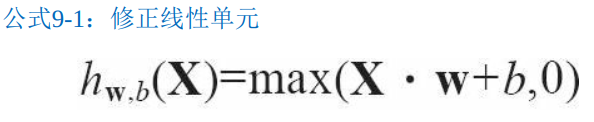

In [232]:
reset_graph()

n_features = 3
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.compat.v1.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.compat.v1.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

Much better, using a function to build the ReLUs:

In [243]:
reset_graph()

# 模块化
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
# add_n（）创建了一个会计算一个张量列表的和的操作
output = tf.add_n(relus, name="output")

In [244]:
save_graph(run_id="relu1")

'tf_logs/run-relu1/'

In [245]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 23:51:42 ago. (Use '!kill 11052' to kill it.)

Even better using name scopes:

In [247]:
reset_graph()

# 模块化
def relu(X):
#     采用命名空间
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # not shown in the book
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")    # not shown
        b = tf.Variable(0.0, name="bias")                             # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                      # not shown
        return tf.maximum(z, 0., name="max")                          # not shown

In [248]:
n_features = 3
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [249]:
save_graph(run_id="relu2")

'tf_logs/run-relu2/'

In [250]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 23:52:12 ago. (Use '!kill 11052' to kill it.)

## Sharing Variables

Sharing a `threshold` variable the classic way, by defining it outside of the `relu()` function then passing it as a parameter:

In [253]:
reset_graph()
# 通过一个共享的阈值变量来控制所有ReLU的阈值
def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [263]:
reset_graph()

def relu(X):
#     命名空间
    with tf.name_scope("relu"):
#         第一次调用时将共享变量设置为relu（） 函数的一个属性
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

In [264]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [265]:
reset_graph()
# 变量空间
with tf.compat.v1.variable_scope("relu"):
# 先通过get_variable（） 函数创建共享变量； 如果已经存在了， 就复用该共享变量。 
# 期望的行为通过当前variable_scope（） 的一个属性来控制（创建或者复用） 。
    threshold = tf.compat.v1.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [267]:
# 变量空间
# 如果要复用一个变量，需要通过设置变量作用域的reuse属性为True来显式地实现（在这里，不必指定形状或初始化器）
# 这段代码会获取既有的"relu/threshold"变量，如果该变量不存在
# 或者在调用get_variable（）时没有创建成功，那么会抛出一个异常。
with tf.compat.v1.variable_scope("relu", reuse=True):
    
# 先通过get_variable（） 函数创建共享变量； 如果已经存在了， 就复用该共享变量。 
# 期望的行为通过当前variable_scope（） 的一个属性来控制（创建或者复用） 。
    threshold = tf.compat.v1.get_variable("threshold")

In [270]:
# 在调用作用域的reuse_variables（）方法块中设置reuse属性为True：
with tf.compat.v1.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.compat.v1.get_variable("threshold")

In [271]:
reset_graph()

def relu(X):
#     复用变量
    with tf.compat.v1.variable_scope("relu", reuse=True):
        threshold = tf.compat.v1.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
# 创建变量
with tf.compat.v1.variable_scope("relu"):
    threshold = tf.compat.v1.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [272]:
save_graph(run_id="relu6")

'tf_logs/run-relu6/'

In [273]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 1 day, 0:40:34 ago. (Use '!kill 11052' to kill it.)

In [283]:
reset_graph()

def relu(X):
#     使用变量 若没有则初始化
    with tf.compat.v1.variable_scope("relu"):
        threshold = tf.compat.v1.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
# 创建变量空间
with tf.compat.v1.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

In [284]:
save_graph(run_id="relu8")

'tf_logs/run-relu8/'

In [285]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 1 day, 1:06:43 ago. (Use '!kill 11052' to kill it.)

In [286]:
reset_graph()

def relu(X):
#     使用变量
    threshold = tf.compat.v1.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.compat.v1.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
#     创建变量空间
    with tf.compat.v1.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [287]:
save_graph(run_id="relu9")

'tf_logs/run-relu9/'

In [288]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 1 day, 1:06:47 ago. (Use '!kill 11052' to kill it.)

# Extra material

In [292]:
reset_graph()

#     创建变量空间
with tf.compat.v1.variable_scope("my_scope"):
#     获取变量(含初始化)
    x0 = tf.compat.v1.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

#     创建变量空间
with tf.compat.v1.variable_scope("my_scope", reuse=True):
    #     获取变量(不含初始化)
    x3 = tf.compat.v1.get_variable("x")
    x4 = tf.Variable(0., name="x")

#     创建变量空间
with tf.compat.v1.variable_scope("", default_name="", reuse=True):
    x5 = tf.compat.v1.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


The first `variable_scope()` block first creates the shared variable `x0`, named `my_scope/x`. For all operations other than shared variables (including non-shared variables), the variable scope acts like a regular name scope, which is why the two variables `x1` and `x2` have a name with a prefix `my_scope/`. Note however that TensorFlow makes their names unique by adding an index: `my_scope/x_1` and `my_scope/x_2`.

The second `variable_scope()` block reuses the shared variables in scope `my_scope`, which is why `x0 is x3`. Once again, for all operations other than shared variables it acts as a named scope, and since it's a separate block from the first one, the name of the scope is made unique by TensorFlow (`my_scope_1`) and thus the variable `x4` is named `my_scope_1/x`.

The third block shows another way to get a handle on the shared variable `my_scope/x` by creating a `variable_scope()` at the root scope (whose name is an empty string), then calling `get_variable()` with the full name of the shared variable (i.e. `"my_scope/x"`).

## Strings

In [295]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.compat.v1.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


## Autodiff

Note: the autodiff content was moved to the [extra_autodiff.ipynb](extra_autodiff.ipynb) notebook.

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

First, let's create the moons dataset using Scikit-Learn's `make_moons()` function:

In [349]:
from sklearn.datasets import make_moons
# 加载数据
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Let's take a peek at the dataset:

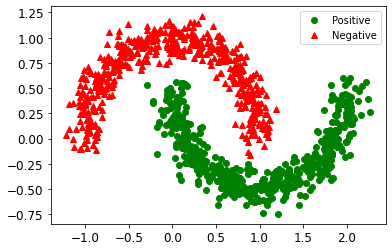

In [350]:
# 绘制图形
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. For this, we just need to add a column full of 1s on the left of the input matrix $\mathbf{X}$:

In [351]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

Let's check:

In [352]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

Looks good. Now let's reshape `y_train` to make it a column vector (i.e. a 2D array with a single column):

In [353]:
y_moons_column_vector = y_moons.reshape(-1, 1)

Now let's split the data into a training set and a test set:

In [354]:
# 训练集和测试集
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

Ok, now let's create a small function to generate training batches. In this implementation we will just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact it will generally cover only about two thirds of the instances). However, in practice this is not an issue and it simplifies the code:

In [355]:
# 打乱数据
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Let's look at a small batch:

In [356]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [357]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]], dtype=int64)

Great! Now that the data is ready to be fed to the model, we need to build that model. Let's start with a simple implementation, then we will add all the bells and whistles.

First let's reset the default graph.

In [358]:
reset_graph()

The _moons_ dataset has two input features, since each instance is a point on a plane (i.e., 2-Dimensional):

In [359]:
n_inputs = 2

Now let's build the Logistic Regression model. As we saw in chapter 4, this model first computes a weighted sum of the inputs (just like the Linear Regression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$\hat{p} = h_\boldsymbol{\theta}(\mathbf{x}) = \sigma(\boldsymbol{\theta}^T \mathbf{x})$


Recall that $\boldsymbol{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, \dots, \theta_n$. The input vector $\mathbf{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, \dots, x_n$.

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \boldsymbol{\theta})$

That's all we need to build the model:

In [360]:
# 占位符
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")
# 变量theta
theta = tf.Variable(tf.compat.v1.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
# 回归
logits = tf.matmul(X, theta, name="logits")
# 预测
y_proba = 1 / (1 + tf.exp(-logits))

In fact, TensorFlow has a nice function `tf.sigmoid()` that we can use to simplify the last line of the previous code:

In [362]:
# sigmoid预测
y_proba = tf.sigmoid(logits)

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} \log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) \log\left(1 - \hat{p}^{(i)}\right)\right]}$

One option is to implement it ourselves:

In [363]:
epsilon = 1e-7  # to avoid an overflow when computing the log
# 损失函数
loss = -tf.reduce_mean(y * tf.compat.v1.log(y_proba + epsilon) + (1 - y) * tf.compat.v1.log(1 - y_proba + epsilon))

But we might as well use TensorFlow's `tf.losses.log_loss()` function:

In [364]:
# 损失函数
loss = tf.compat.v1.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

The rest is pretty standard: let's create the optimizer and tell it to minimize the cost function:

In [365]:
learning_rate = 0.01
# 梯度下降优化
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
# 损失函数最小化
training_op = optimizer.minimize(loss)

All we need now (in this minimal version) is the variable initializer:

In [366]:
# 全局变量初始化
init = tf.compat.v1.global_variables_initializer()

And we are ready to train the model and use it for predictions!

There's really nothing special about this code, it's virtually the same as the one we used earlier for Linear Regression:

In [367]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
#             数据分割
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
#             训练
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#             损失函数
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
# 预测
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.79260236
Epoch: 100 	Loss: 0.34346348
Epoch: 200 	Loss: 0.3075404
Epoch: 300 	Loss: 0.29288894
Epoch: 400 	Loss: 0.28533572
Epoch: 500 	Loss: 0.28047806
Epoch: 600 	Loss: 0.27808294
Epoch: 700 	Loss: 0.2761544
Epoch: 800 	Loss: 0.27551997
Epoch: 900 	Loss: 0.27491233


Note: we don't use the epoch number when generating batches, so we could just have a single `for` loop rather than 2 nested `for` loops, but it's convenient to think of training time in terms of number of epochs (i.e., roughly the number of times the algorithm went through the training set).

For each instance in the test set, `y_proba_val` contains the estimated probability that it belongs to the positive class, according to the model. For example, here are the first 5 estimated probabilities:

In [368]:
y_proba_val[:5]

array([[0.54895616],
       [0.7072436 ],
       [0.5190026 ],
       [0.99111354],
       [0.5085905 ]], dtype=float32)

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [369]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision). See chapter 3 for more details.

Let's compute the model's precision and recall:

In [370]:
from sklearn.metrics import precision_score, recall_score
# 精度 召回率

precision_score(y_test, y_pred)

0.8627450980392157

In [371]:
recall_score(y_test, y_pred)

0.8888888888888888

Let's plot these predictions to see what they look like:

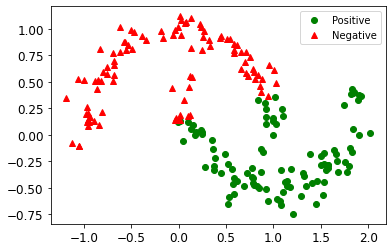

In [372]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Well, that looks pretty bad, doesn't it? But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
* Define the graph within a `logistic_regression()` function that can be reused easily.
* Save checkpoints using a `Saver` at regular intervals during training, and save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using `sklearn.preprocessing.PolynomialFeatures`.

In [373]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

This is what the "enhanced" training set looks like:

In [374]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

Ok, next let's reset the default graph:

In [375]:
reset_graph()

Now let's define the `logistic_regression()` function to create the graph. We will leave out the definition of the inputs `X` and the targets `y`. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [376]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
#     逻辑回归命名空间
    with tf.name_scope("logistic_regression"):
#         model空间
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.compat.v1.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
#             训练空间
        with tf.name_scope("train"):
            loss = tf.compat.v1.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.compat.v1.summary.scalar('log_loss', loss)
#             初始化
        with tf.name_scope("init"):
            init = tf.compat.v1.global_variables_initializer()
#             保存
        with tf.name_scope("save"):
            saver = tf.compat.v1.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [377]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next, let's create the graph, using the `logistic_regression()` function. We will also create the `FileWriter` to save the summaries to the log directory for Tensorboard:

In [378]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called `global_step` that we pass to the optimizer's `minimize()` method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [379]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.compat.v1.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
#         分批次训练
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#             计算损失函数
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
#         保存
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

file_writer.close()

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122364
Epoch: 1000 	Loss: 0.119032085
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369794
Epoch: 2500 	Loss: 0.07437582
Epoch: 3000 	Loss: 0.067502156
Epoch: 3500 	Loss: 0.062206894
Epoch: 4000 	Loss: 0.058026794
Epoch: 4500 	Loss: 0.05456298
Epoch: 5000 	Loss: 0.05170829
Epoch: 5500 	Loss: 0.049237728
Epoch: 6000 	Loss: 0.047167297
Epoch: 6500 	Loss: 0.04537666
Epoch: 7000 	Loss: 0.04381875
Epoch: 7500 	Loss: 0.04237423
Epoch: 8000 	Loss: 0.041089162
Epoch: 8500 	Loss: 0.039970916
Epoch: 9000 	Loss: 0.038920254
Epoch: 9500 	Loss: 0.038010746
Epoch: 10000 	Loss: 0.037155695


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [380]:
y_pred = (y_proba_val >= 0.5)

In [381]:
precision_score(y_test, y_pred)

0.9797979797979798

In [382]:
recall_score(y_test, y_pred)

0.9797979797979798

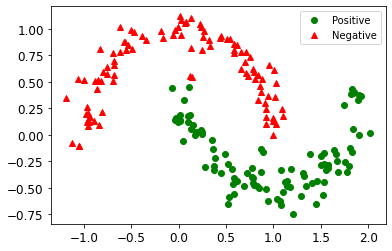

In [383]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now that's much, much better! Apparently the new features really helped a lot.

Let's open tensorboard, find the latest run and look at the learning curve:

In [384]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6006 (pid 11052), started 1 day, 1:45:39 ago. (Use '!kill 11052' to kill it.)

Now you can play around with the hyperparameters (e.g. the `batch_size` or the `learning_rate`) and run training again and again, comparing the learning curves. You can even automate this process by implementing grid search or randomized search. Below is a simple implementation of a randomized search on both the batch size and the learning rate. For the sake of simplicity, the checkpoint mechanism was removed.

In [ ]:
# 倒数
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

file_writer.close()

Iteration 0
  logdir: tf_logs/logreg-run-20211209090034/
  batch size: 54
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20211209090143/
  batch size: 22
  learning_rate: 0.0017826497151386947
  training: ........

The `reciprocal()` function from SciPy's `stats` module returns a random distribution that is commonly used when you have no idea of the optimal scale of a hyperparameter. See the exercise solutions for chapter 2 for more details. 